In [2]:
import pandas as pd
import os
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [3]:
path1 = "/Users/soglelaw/Desktop/Inspirit AI Project/archive/ADHD-comment.csv"
path2 = "/Users/soglelaw/Desktop/Inspirit AI Project/archive/ADHD.csv"

In [4]:
data1 = pd.read_csv(path1, encoding='latin1', on_bad_lines='skip', low_memory=False, nrows=1000000)
data2 = pd.read_csv(path2, encoding='latin1', on_bad_lines='skip', low_memory=False, nrows=1000000)




In [5]:
data1.head()

,body,id,score,created_utc,created_datetime
0,[deleted],c08otkh,1.0,1.239042e+09,2009-04-06 18:18:07
1,If I try to look this up right now I will get ...,c09y8qz,2.0,1.243790e+09,2009-05-31 17:08:19
2,potassium is used as the thing that stops your...,c09yia6,2.0,1.243815e+09,2009-06-01 00:07:50
3,I've love a link to anything about this. \n\n...,c0a81e6,3.0,1.244752e+09,2009-06-11 20:25:36
4,"I don't know anything specific, but I would *d...",c0aixrg,2.0,1.245813e+09,2009-06-24 03:04:51


In [6]:
data2.head()

,title,selftext,score,id,url,num_comments,created_utc,created_datetime
0,Android app to strengthen attention/focus,"Hey /r/ADHD,\n\nCheck out my simple Android ap...",6,k348a,https://www.reddit.com/r/ADHD/comments/k348a/a...,7.0,1315014480.0,2011-09-03 01:48:00
1,Does anyone here have experience with Imipramine?,My doctor has suggested it for ADD with anxiet...,4,k3gdz,https://www.reddit.com/r/ADHD/comments/k3gdz/d...,1.0,1315051084.0,2011-09-03 11:58:04
2,"New study shows that for people with ADHD, \n""...",NaN,22,k4q79,http://www.utexas.edu/features/2011/08/29/adhd...,11.0,1315174374.0,2011-09-04 22:12:54
3,What does the ADHD test look like?,I'm 21 and didn't know about ADHD until recent...,6,k5fvd,https://www.reddit.com/r/ADHD/comments/k5fvd/w...,10.0,1315239683.0,2011-09-05 16:21:23
4,Are you guys good with maps and directions?,It seems like one thing I've always been reall...,0,k6efi,https://www.reddit.com/r/ADHD/comments/k6efi/a...,0.0,1315317191.0,2011-09-06 13:53:11


In [7]:
import nltk
import nltk.tokenize.punkt
#import nltk.tokenize.stopwords
#import nltk.tokenize.wordnet
print(nltk.data.path)
os.environ["DEFAULT_URL"] = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml'
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

['/Users/soglelaw/nltk_data', '/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/nltk_data', '/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/share/nltk_data', '/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/soglelaw/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/soglelaw/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/soglelaw/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
def preprocess_comments(data, text_column='body', score_column='score', test_size=0.2, random_state=42):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    X = data[text_column]
    Y = data[score_column]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    num_samples_train = X_train.shape[0]
    num_samples_test = X_test.shape[0]

    print(f"num_samples_train = {num_samples_train}")
    print(f"num_samples_test = {num_samples_test}")

    def preprocess_text(series):
        tokenized = series.apply(lambda x: word_tokenize(str(x)))
        no_stopwords = tokenized.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation])
        lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
        preprocessed = lemmatized.apply(lambda tokens: ' '.join(tokens))
        return preprocessed

    X_train_preprocessed = preprocess_text(X_train)
    X_test_preprocessed = preprocess_text(X_test)

    vectorizer = TfidfVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train_preprocessed)
    X_test_vectorized = vectorizer.transform(X_test_preprocessed)

    print(X_train_vectorized.shape)
    print(X_test_vectorized.shape)

    X_combined = pd.concat([X_train_preprocessed, X_test_preprocessed])
    X_combined_vectorized = vectorizer.fit_transform(X_combined)

    print(f'Dimensions of the entire dataset: {X_combined_vectorized.shape}')

    return X_train_vectorized, X_test_vectorized, y_train, y_test, X_combined_vectorized, vectorizer


In [10]:
def preprocess_posts(data, text_column='selftext', score_column='score', test_size=0.2, random_state=42):
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    X = data[text_column]
    Y = data[score_column]

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)

    num_samples_train = X_train.shape[0]
    num_samples_test = X_test.shape[0]

    print(f"num_samples_train = {num_samples_train}")
    print(f"num_samples_test = {num_samples_test}")

    def preprocess_text(series):
        tokenized = series.apply(lambda x: word_tokenize(str(x)))
        no_stopwords = tokenized.apply(lambda tokens: [word for word in tokens if word.lower() not in stop_words and word not in string.punctuation])
        lemmatized = no_stopwords.apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
        preprocessed = lemmatized.apply(lambda tokens: ' '.join(tokens))
        return preprocessed

    X_train_preprocessed = preprocess_text(X_train)
    X_test_preprocessed = preprocess_text(X_test)

    vectorizer = TfidfVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train_preprocessed)
    X_test_vectorized = vectorizer.transform(X_test_preprocessed)

    print(X_train_vectorized.shape)
    print(X_test_vectorized.shape)

    X_combined = pd.concat([X_train_preprocessed, X_test_preprocessed])
    X_combined_vectorized = vectorizer.fit_transform(X_combined)

    print(f'Dimensions of the entire dataset: {X_combined_vectorized.shape}')

    return X_train_vectorized, X_test_vectorized, y_train, y_test, X_combined_vectorized, vectorizer


In [7]:
def calculate_word_score_correlation(X_vectorized, scores, vectorizer):
    words_df = pd.DataFrame(X_vectorized.toarray(), columns=vectorizer.get_feature_names_out())
    if isinstance(scores, pd.Series):
        words_df['score'] = scores.reset_index(drop=True)
    else:
        words_df['score'] = pd.Series(scores).reset_index(drop=True)
    correlations = words_df.corr()['score'].sort_values(ascending=False)
    return correlations


In [8]:
def plot_top_correlations(correlations, n=20):
    if isinstance(correlations, pd.Series):
        correlations = correlations.head(n)
    else:
        correlations = pd.Series(correlations).head(n)

    top_positive_correlations = correlations[correlations > 0]
    top_negative_correlations = correlations[correlations < 0]

    plt.figure(figsize=(12, 8))

    plt.subplot(1, 2, 1)
    sns.barplot(x=top_positive_correlations.values, y=top_positive_correlations.index)
    plt.title('Top Positive Word Correlations with Score')
    plt.xlabel('Correlation')


In [11]:
X_train_vectorized, X_test_vectorized, y_train, y_test, X_combined_vectorized, vectorizer = preprocess_comments(data1, 'body', 'score')
correlations = calculate_word_score_correlation(X_combined_vectorized, pd.concat([y_train, y_test]), vectorizer)
plot_top_correlations(correlations)


NameError: name 'data1' is not defined

In [20]:
import nltk
print(nltk.data.path)

['/Users/soglelaw/nltk_data', '/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/nltk_data', '/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/share/nltk_data', '/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [ ]:
X_train_vectorized, X_test_vectorized, y_train, y_test, X_combined_vectorized, vectorizer = preprocess_posts(data2, 'selftext', 'score')
correlations = calculate_word_score_correlation(X_combined_vectorized, pd.concat([y_train, y_test]), vectorizer)
plot_top_correlations(correlations)


In [ ]:
X_train_vectorized, X_test_vectorized, y_train, y_test, X_combined_vectorized, vectorizer = preprocess_posts(data3, 'selftext', 'score')
correlations = calculate_word_score_correlation(X_combined_vectorized, pd.concat([y_train, y_test]), vectorizer)
plot_top_correlations(correlations)


In [ ]:
X_train_vectorized, X_test_vectorized, y_train, y_test, X_combined_vectorized, vectorizer = preprocess_comments(data4, 'body', 'score')
correlations = calculate_word_score_correlation(X_combined_vectorized, pd.concat([y_train, y_test]), vectorizer)
plot_top_correlations(correlations)


In [ ]:
def create_word_cloud(text):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

def combine_text_data(data, text_column):
    combined_text = " ".join(data[text_column].dropna().tolist())
    return combined_text


In [ ]:
combined_text1 = combine_text_data(data1, 'body')
create_word_cloud(combined_text1)

In [ ]:
combined_text2 = combine_text_data(data2, 'selftext')
create_word_cloud(combined_text2)

In [ ]:
combined_text3 = combine_text_data(data3, 'selftext')
create_word_cloud(combined_text3)

In [ ]:
combined_text4 = combine_text_data(data4, 'body')
create_word_cloud(combined_text4)

In [ ]:
def preprocess_text(text: str) -> str:
    text = re.sub(r"http\S+", "", text)
    text = re.sub("[^A-Za-z]+", " ", text)
    tokens = nltk.word_tokenize(text)
    tokens = [w for w in tokens if not w.lower() in stopwords.words("english")]
    text = " ".join(tokens)
    text = text.lower().strip()
    return text

In [ ]:
data1['text_cleaned'] = data1['body'].apply(lambda text: preprocess_text(text))
data1 = data1[data1['text_cleaned'] != '']
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
X_tfidf = vectorizer.fit_transform(data1['text_cleaned']).toarray()

In [ ]:
def eval_cluster(embedding):
    y_pred = kmeans.fit_predict(embedding)
    #ari = adjusted_rand_score(data1["target"], y_pred)
    #nmi = normalized_mutual_info_score(data1["target"], y_pred)
    #fmi = fowlkes_mallows_score(data1["target"], y_pred)

    #print("Adjusted Rand Index (ARI): {:.3f}".format(ari))
    #print("Normalized Mutual Information (NMI): {:.3f}".format(nmi))
    #print("Fowlkes-Mallows Index (FMI): {:.3f}".format(fmi))

kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(X_tfidf)

clusters = kmeans.labels_

data1['cluster_tfidf'] = clusters

eval_cluster(X_tfidf)


In [ ]:
def dimension_reduction(embedding, method):
    pca = PCA(n_components=2, random_state=42)
    pca_vecs = pca.fit_transform(embedding)
    data1[f'x0_{method}'] = pca_vecs[:, 0]
    data1[f'x1_{method}'] = pca_vecs[:, 1]
dimension_reduction(X_tfidf, 'tfidf')


In [ ]:
def plot_pca(x0_name, x1_name, cluster_name, method):
    plt.figure(figsize=(12, 7))
    plt.title(f"TF-IDF + KMeans Clustering with {method}", fontdict={"fontsize": 18})
    plt.xlabel("X0", fontdict={"fontsize": 16})
    plt.ylabel("X1", fontdict={"fontsize": 16})
    sns.scatterplot(data=data2, x=x0_name, y=x1_name, hue=cluster_name, palette="viridis")
    plt.show()

plot_pca('x0_tfidf', 'x1_tfidf', 'cluster_tfidf', 'TF-IDF')


In [ ]:
# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_tfidf)  # Assuming X_tfidf is your tf-idf matrix
    wcss.append(kmeans.inertia_)

# Plot the elbow method
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()


In [ ]:
from sklearn.metrics import silhouette_score
sil_coeff = silhouette_score(X_tfidf, clusters)
print("Silhouette Coefficient:", round(sil_coeff, 3))

In [ ]:
from sklearn.metrics import calinski_harabasz_score

# Calculate the Calinski-Harabasz Index
ch_index = calinski_harabasz_score(X_tfidf, clusters)
print("Calinski-Harabasz Index:", round(ch_index, 3))


In [ ]:
from sklearn.metrics import davies_bouldin_score
clusters = kmeans.labels_
data1['cluster_tfidf'] = clusters
dbi = davies_bouldin_score(X_tfidf, clusters)
print("Davies-Bouldin Index:", round(dbi, 3))


### **LDA Topic Modelling**

In [8]:
import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel


## Comments

In [10]:
def preprocess_for_lda(texts):
    # Initialize stopwords and lemmatizer
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

    processed_texts = []

    for text in texts:
        if isinstance(text, str):  # Check if the input is a string
            # Tokenize, lowercase, and filter stopwords and non-alphanumeric tokens
            tokens = word_tokenize(text.lower())
            tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
            processed_texts.append(tokens)
        else:
            # Handle non-string values by appending an empty list or skipping
            processed_texts.append([])

    return processed_texts


In [11]:
from nltk.tokenize import word_tokenize

sample_text = "This is a simple test."
tokens = word_tokenize(sample_text)
print("Tokenized sample:", tokens)

Tokenized sample: ['This', 'is', 'a', 'simple', 'test', '.']


In [13]:
texts = data1['body'].values.tolist()
processed_texts = preprocess_for_lda(texts)
id2word = corpora.Dictionary(processed_texts)

corpus = [id2word.doc2bow(text) for text in processed_texts]


In [14]:
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=4,
                     random_state=42,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     per_word_topics=True)

for idx, topic in lda_model.print_topics(-1):
    print(f"Topic: {idx} \nWords: {topic}")


Topic: 0 
Words: 0.041*"medication" + 0.033*"doctor" + 0.028*"med" + 0.019*"effect" + 0.018*"take" + 0.017*"adderall" + 0.015*"taking" + 0.014*"vyvanse" + 0.011*"drug" + 0.011*"dose"
Topic: 1 
Words: 0.020*"like" + 0.016*"get" + 0.015*"thing" + 0.011*"really" + 0.010*"know" + 0.010*"would" + 0.010*"time" + 0.010*"think" + 0.009*"feel" + 0.009*"help"
Topic: 2 
Words: 0.058*"adhd" + 0.015*"people" + 0.010*"brain" + 0.010*"gt" + 0.009*"symptom" + 0.009*"http" + 0.008*"question" + 0.008*"see" + 0.008*"else" + 0.007*"diagnosis"
Topic: 3 
Words: 0.028*"day" + 0.018*"time" + 0.013*"hour" + 0.011*"sleep" + 0.011*"take" + 0.011*"get" + 0.010*"work" + 0.009*"every" + 0.009*"week" + 0.008*"use"


In [15]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12742) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12742) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12742) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/Users/soglelaw/Desktop/anc/anaconda3/envs/adhd_data_viz/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=12742) is multi-threaded, use of f

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.108134  0.000968       1        1  53.319892
2      0.357043 -0.127738       2        1  18.530143
3     -0.243795 -0.194236       3        1  16.774404
0     -0.005113  0.321006       4        1  11.375561, topic_info=           Term           Freq          Total Category  logprob  loglift
102        adhd  348842.000000  348842.000000  Default  30.0000  30.0000
380  medication  151768.000000  151768.000000  Default  29.0000  29.0000
247      doctor  122311.000000  122311.000000  Default  28.0000  28.0000
334         med  136380.000000  136380.000000  Default  27.0000  27.0000
36          day  178816.000000  178816.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
1          also   30625.729173  167935.213606   Topic4  -4.7961   0.4720
214        week   23720.350477   71269.639934   Topic4  -5.0516   1.0736
691         may   21810.803821   65267.120723   Topic4  -5.1356   1.0776
175       first   22256.933770   84839.189588   Topic4  -5.1153   0.8356
36          day   23510.858417  178816.528422   Topic4  -5.0605   0.1448

[222 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
479       3  0.999934     1
451       3  0.757977     2
451       4  0.241996     2
215       3  0.999981     3
2481      3  0.999929    30
...     ...       ...   ...
438       1  0.999969  yeah
300       1  0.990570  year
300       4  0.009425  year
917       1  0.332506   yes
917       2  0.667490   yes

[258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 4, 1])

In [11]:
from gensim.models import CoherenceModel
from gensim.models.ldamodel import LdaModel


In [12]:
def compute_coherence_values(corpus, dictionary, texts, limit, start=2, step=3, alpha_values=None, beta_values=None):
    coherence_values = []
    model_list = []

    for alpha in alpha_values:
        for beta in beta_values:
            for num_topics in range(start, limit, step):
                model = LdaModel(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=num_topics,
                                 random_state=100,
                                 chunksize=100,
                                 passes=10,
                                 alpha=alpha,
                                 eta=beta)

                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [13]:
start = 2
limit = 10
step = 2

alpha_values = ['auto', 'asymmetric', 0.01, 0.31]
beta_values = ['auto', 'symmetric', 0.01, 0.31]

model_list, coherence_values = compute_coherence_values(corpus=corpus,
                                                        dictionary=id2word,
                                                        texts=processed_texts,
                                                        start=start,
                                                        limit=limit,
                                                        step=step,
                                                        alpha_values=alpha_values,
                                                        beta_values=beta_values)


In [ ]:
# final steps:
# create table with three columns and sort the table by coherence score
# create wordclouds for each of the five clusters that we have in the LDA model
# calculate the coherence score for num_topic values 0-10 in the LDA model
# segment our data by year (2009-2021), loop through each year and run the LDA model so we can see how the topics we uncovered are shifting over time?

In [ ]:
num_topics_list = []
alpha_list = []
beta_list = []
coherence_score_list = []

for i, (alpha, beta) in enumerate(zip(alpha_values, beta_values)):
    for j, num_topics in enumerate(range(start, limit, step)):
        num_topics_list.append(num_topics)
        alpha_list.append(alpha)
        beta_list.append(beta)
        coherence_score_list.append(coherence_values[i * len(range(start, limit, step)) + j])

results_df = pd.DataFrame({
    'num_topics': num_topics_list,
    'alpha': alpha_list,
    'beta': beta_list,
    'coherence_score': coherence_score_list
})

sorted_df = results_df.sort_values(by='coherence_score', ascending=False)
sorted_df.reset_index(drop=True, inplace=True)

print(sorted_df)


    num_topics       alpha       beta  coherence_score
0            2        auto       auto         0.627251
1            2  asymmetric  symmetric         0.627251
2            2        0.31       0.31         0.605961
3            6        0.31       0.31         0.583611
4            2        0.01       0.01         0.579149
5            4        0.31       0.31         0.577018
6            4        auto       auto         0.570212
7            4  asymmetric  symmetric         0.570212
8            4        0.01       0.01         0.546914
9            6        auto       auto         0.540770
10           6  asymmetric  symmetric         0.540770
11           6        0.01       0.01         0.488534
12           8        0.31       0.31         0.446643
13           8        auto       auto         0.438205
14           8  asymmetric  symmetric         0.438205
15           8        0.01       0.01         0.396020


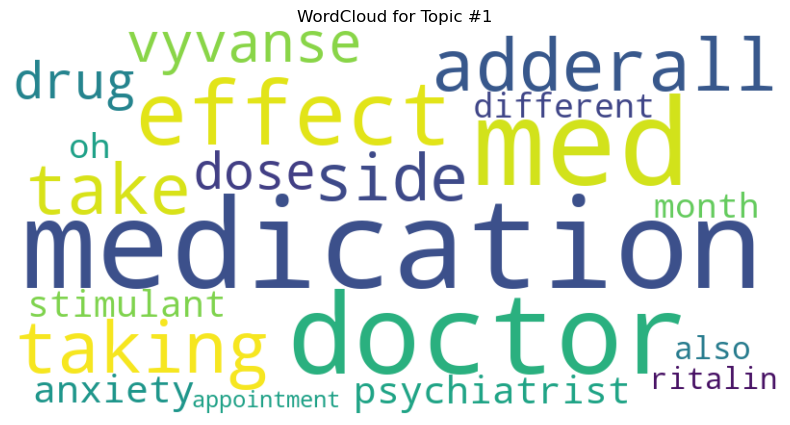

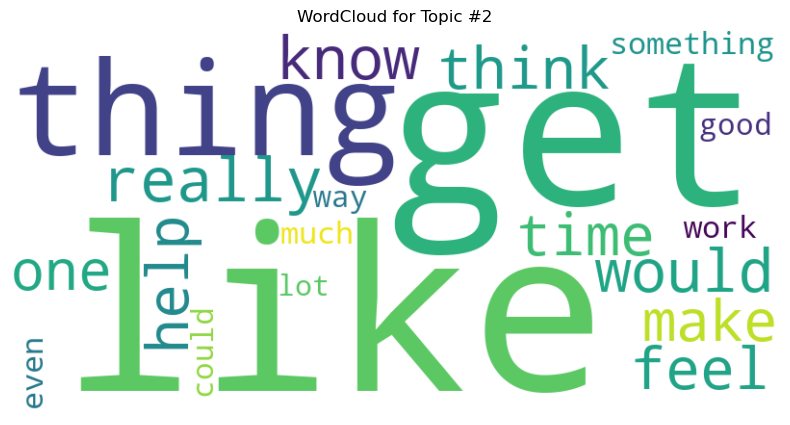

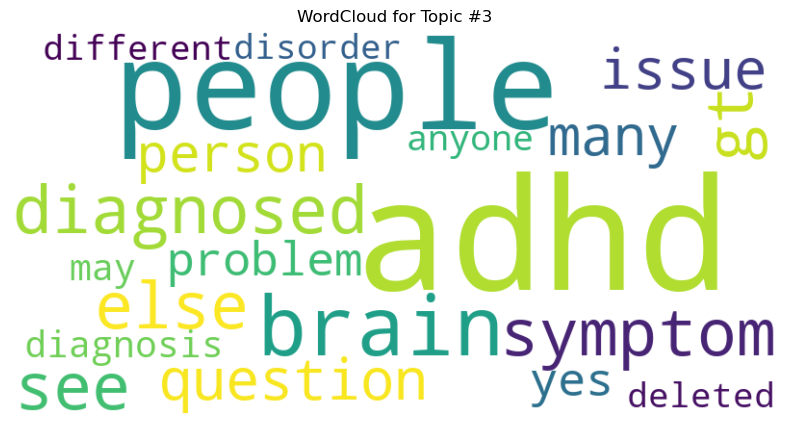

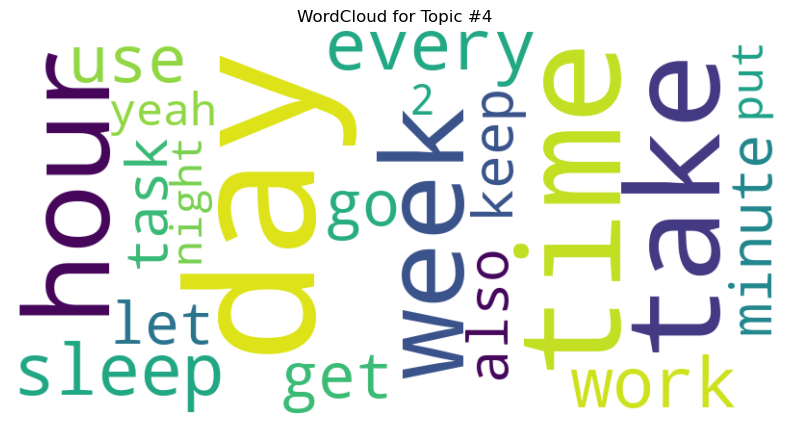

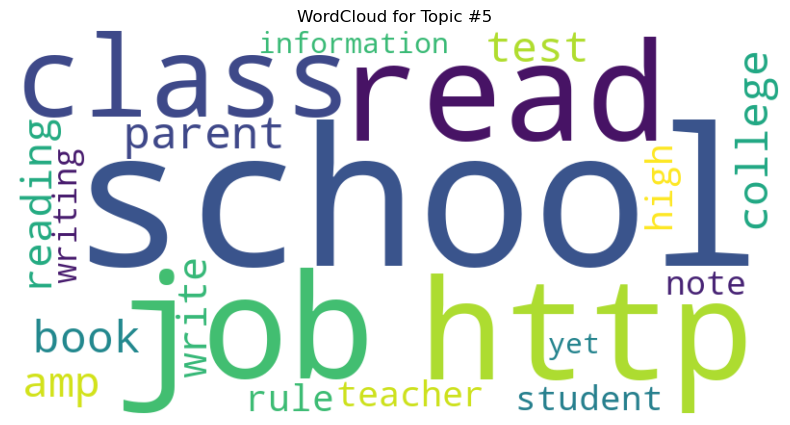

In [ ]:
for topic_idx in range(lda_model.num_topics):
    words = dict(lda_model.show_topic(topic_idx, topn=20))

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(words)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for Topic #{topic_idx + 1}")
    plt.show()


Coherence Score for num_topics=1: 0.5529724672609899
Coherence Score for num_topics=2: 0.6272513493569911
Coherence Score for num_topics=3: 0.560459257340246
Coherence Score for num_topics=4: 0.5702116758833382
Coherence Score for num_topics=5: 0.5501562964130853
Coherence Score for num_topics=6: 0.54077036201136
Coherence Score for num_topics=7: 0.510629885552562
Coherence Score for num_topics=8: 0.4382049989438732
Coherence Score for num_topics=9: 0.4681828593504372
Coherence Score for num_topics=10: 0.4028118928427017


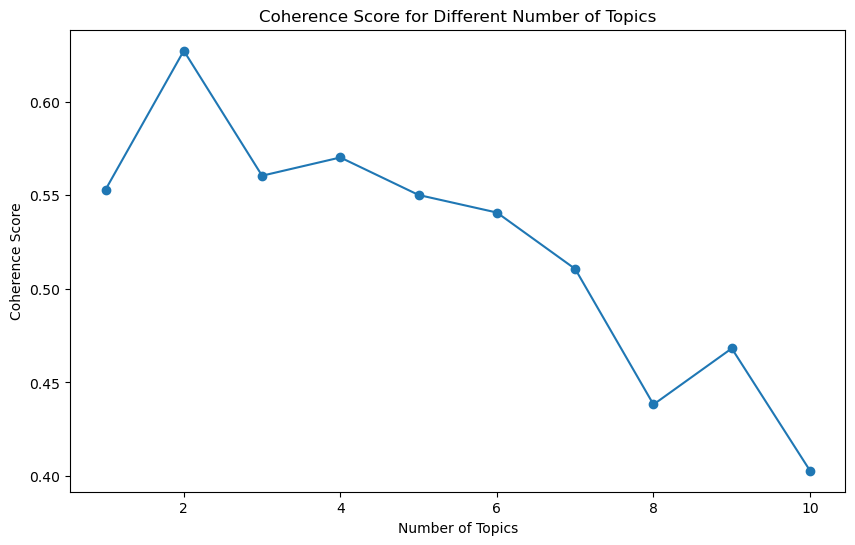

In [ ]:
from gensim.models import CoherenceModel

topic_range = range(1, 11)

coherence_scores = []

for num_topics in topic_range:
    lda_model = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         random_state=100,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         per_word_topics=True)

    coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_texts, dictionary=id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    coherence_scores.append(coherence_score)
    print(f'Coherence Score for num_topics={num_topics}: {coherence_score}')

plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.title('Coherence Score for Different Number of Topics')
plt.show()
